In [6]:
import numpy as np
import pandas as pd
from math import pi
from scipy import stats
import matplotlib.pyplot as plt

Gaussian elimination solution (x1..x4): [37.5 37.5 12.5 12.5]
Maximum |T'(x)| = 31.4159 °C/unit. Occurs at x (in [0,10]): [ 0. 10.]


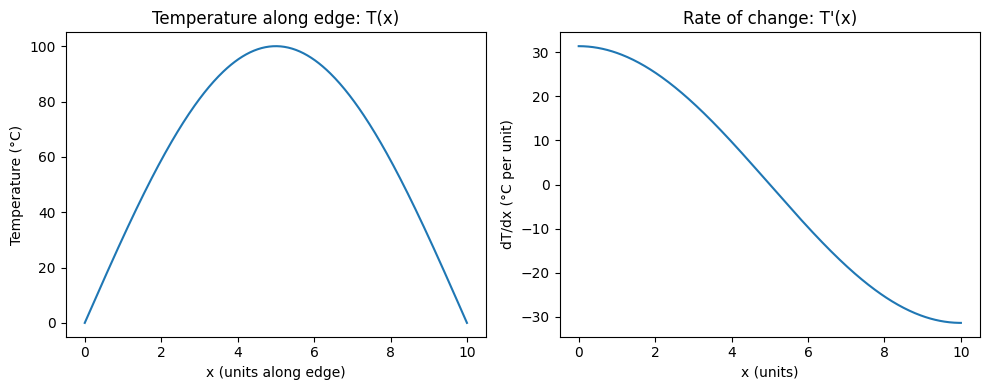

P(error > 3°C) for N(0,2): 0.066807


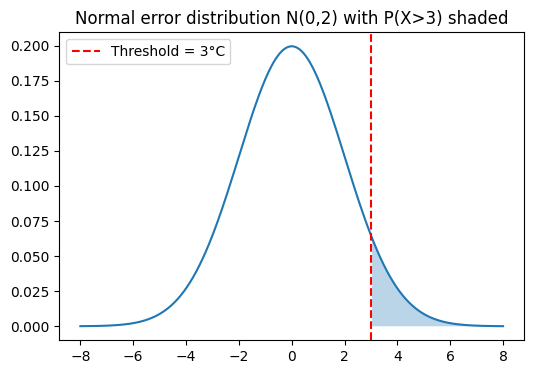


Sample measurements: [ 99 100  98 101  97  99 100  98]
Sample mean = 99.000, s = 1.309, n = 8
t-statistic = -2.1602, two-sided p-value = 0.0676
Fail to reject H0 at alpha=0.05: no evidence mean differs from 100


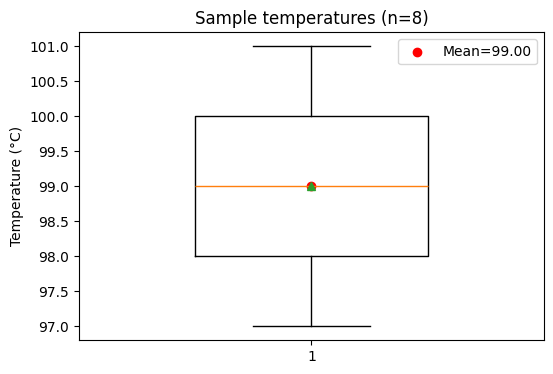

In [15]:
# 1) Gaussian elimination
def gaussian_elimination(A, b):
    """
    Solves Ax = b using Gaussian elimination with partial pivoting.
    A: square numpy array (n x n)
    b: right-hand side vector (n,)
    Returns x as numpy array.
    """
    A = A.astype(float).copy()
    b = b.astype(float).copy()
    n = A.shape[0]

    for k in range(n - 1):
        max_row = np.argmax(np.abs(A[k:, k])) + k
        if A[max_row, k] == 0:
            raise ValueError("Matrix is singular or nearly singular.")
        # Swap rows if needed
        if max_row != k:
            A[[k, max_row], :] = A[[max_row, k], :]
            b[[k, max_row]] = b[[max_row, k]]

        # Eliminate below
        for i in range(k + 1, n):
            factor = A[i, k] / A[k, k]
            A[i, k:] = A[i, k:] - factor * A[k, k:]
            b[i] = b[i] - factor * b[k]

    # Back substitution
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        if A[i, i] == 0:
            raise ValueError("Zero diagonal element during back substitution.")
        x[i] = (b[i] - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]
    return x

A = np.array([[4, -1, -1, 0],
              [-1, 4, 0, -1],
              [-1, 0, 4, -1],
              [0, -1, -1, 4]], dtype=float)
b = np.array([100, 100, 0, 0], dtype=float)

x_solution = gaussian_elimination(A, b)
print("Gaussian elimination solution (x1..x4):", x_solution)

# 2) Temperature function and where it changes fastest

def T(x):
    return 100 * np.sin((pi * x) / 10)
def T_prime(x):
    return 100 * (pi / 10) * np.cos((pi * x) / 10)
domain_x = np.linspace(0, 10, 401)
t_vals = T(domain_x)
tp_vals = T_prime(domain_x)
max_abs_tp = np.max(np.abs(tp_vals))
max_points = domain_x[np.isclose(np.abs(tp_vals), max_abs_tp)]

print(f"Maximum |T'(x)| = {max_abs_tp:.4f} °C/unit. Occurs at x (in [0,10]): {np.unique(np.round(max_points, 6))}")

# Plot temperature and derivative for visualization
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(domain_x, t_vals)
plt.title("Temperature along edge: T(x)")
plt.xlabel("x (units along edge)")
plt.ylabel("Temperature (°C)")

plt.subplot(1,2,2)
plt.plot(domain_x, tp_vals)
plt.title("Rate of change: T'(x)")
plt.xlabel("x (units)")
plt.ylabel("dT/dx (°C per unit)")
plt.tight_layout()
plt.show()

# 3) Probability that a N(0, 2) error > 3°C

mu_error = 0
sigma_error = 2
threshold = 3
# P(X > 3) = survival function at 3
prob_gt_3 = stats.norm.sf(threshold, loc=mu_error, scale=sigma_error)
print(f"P(error > 3°C) for N(0,2): {prob_gt_3:.6f}")

# Visualize the error distribution and threshold
x_range = np.linspace(-8, 8, 401)
pdf_vals = stats.norm.pdf(x_range, loc=mu_error, scale=sigma_error)
plt.figure(figsize=(6,4))
plt.plot(x_range, pdf_vals)
plt.fill_between(x_range, 0, pdf_vals, where=(x_range>threshold), alpha=0.3)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}°C')
plt.title("Normal error distribution N(0,2) with P(X>3) shaded")
plt.legend()
plt.show()

# 4) One-sample t-test for sample of 8 measurements
measurements = np.array([99, 100, 98, 101, 97, 99, 100, 98])
n = len(measurements)
sample_mean = measurements.mean()
sample_std = measurements.std(ddof=1)
mu0 = 100
alpha = 0.05
t_stat, p_value_two_sided = stats.ttest_1samp(measurements, popmean=mu0)
print("\nSample measurements:", measurements)
print("Sample mean = {:.3f}, s = {:.3f}, n = {}".format(sample_mean, sample_std, n))
print("t-statistic = {:.4f}, two-sided p-value = {:.4f}".format(t_stat, p_value_two_sided))
if p_value_two_sided < alpha:
    print(f"Reject H0 at alpha={alpha}: evidence mean != {mu0}")
else:
    print(f"Fail to reject H0 at alpha={alpha}: no evidence mean differs from {mu0}")

# Visualize sample as boxplot and overlay mean
plt.figure(figsize=(6,4))
plt.boxplot(measurements, vert=True, widths=0.5, showmeans=True)
plt.scatter(1, sample_mean, color='red', label=f'Mean={sample_mean:.2f}')
plt.title("Sample temperatures (n=8)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()